In [1]:
# Run to make the metropolitan_normal_with_best_boroughs.csv and metropolitan_normal_with_worst_boroughs.csv files
# runtime +- 3 hours

# import sqlite3
# import geopandas as gpd
# from shapely.geometry import Point
# from tqdm import tqdm
# import pandas as pd

# # Function to get borough name for a given point
# def get_borough(lon, lat, boroughs_gdf, boroughs_sindex):
#     point = Point(lon, lat)
#     possible_matches_index = list(boroughs_sindex.intersection(point.bounds))
#     possible_matches = boroughs_gdf.iloc[possible_matches_index]
#     for _, borough in possible_matches.iterrows():
#         if borough['geometry'].contains(point):
#             return borough['name']  # Assuming 'name' is the column with the borough names
#     return None

# # List of best and worst boroughs
# best_boroughs = [
#     'Kingston upon Thames', 'Bexley', 'Sutton',
#     'Westminster', 'Kensington and Chelsea'
# ]
# worst_boroughs = [
#     'Hackney', 'Lewisham', 'Haringey', 'Islington', 'Lambeth'
# ]

# # Connect to the SQLite database
# conn = sqlite3.connect('data/crime_data.db')
# cursor = conn.cursor()

# # Load the London boroughs GeoPackage file
# boroughs_gdf = gpd.read_file('data/London_Boroughs.gpkg')
# boroughs_gdf = boroughs_gdf.to_crs(epsg=4326)

# # Create a spatial index on the boroughs for faster lookups
# boroughs_sindex = boroughs_gdf.sindex

# # Define chunk size
# chunk_size = 1000000  # Adjust based on memory capacity and performance
# offset = 0

# # Prepare the CSV files with headers
# best_output_file = 'metropolitan_normal_with_best_boroughs.csv'
# worst_output_file = 'metropolitan_normal_with_worst_boroughs.csv'
# df_columns = ["Crime ID", "Month", "borough", "Crime type", "Last outcome category"]

# # Initialize the files with headers
# pd.DataFrame(columns=df_columns).to_csv(best_output_file, index=False, mode='w')
# pd.DataFrame(columns=df_columns).to_csv(worst_output_file, index=False, mode='w')

# # Process data in chunks
# while True:
#     # Fetch a chunk of rows from the database
#     cursor.execute(
#         'SELECT "Crime ID", Month, Longitude, Latitude, "Crime type", "Last outcome category" '
#         'FROM "metropolitan-normal" LIMIT ? OFFSET ?', (chunk_size, offset)
#     )
#     rows = cursor.fetchall()
    
#     # If no more rows, break the loop
#     if not rows:
#         break
    
#     # Prepare lists to collect the data for the current chunk
#     best_data_for_csv = []
#     worst_data_for_csv = []

#     # Process each row and prepare the data for CSV
#     for row in tqdm(rows, desc=f"Processing rows {offset} to {offset + chunk_size}"):
#         crime_id, month, lon, lat, crime_type, last_outcome = row
#         if lon is not None and lat is not None:
#             borough_name = get_borough(lon, lat, boroughs_gdf, boroughs_sindex)
#             if borough_name:
#                 data_tuple = (crime_id, month, borough_name, crime_type, last_outcome)
#                 if borough_name in best_boroughs:
#                     best_data_for_csv.append(data_tuple)
#                 elif borough_name in worst_boroughs:
#                     worst_data_for_csv.append(data_tuple)
    
#     # Convert the data to DataFrames
#     df_best_chunk = pd.DataFrame(best_data_for_csv, columns=df_columns)
#     df_worst_chunk = pd.DataFrame(worst_data_for_csv, columns=df_columns)

#     # Append the chunk DataFrames to the respective CSV files
#     df_best_chunk.to_csv(best_output_file, index=False, mode='a', header=False)
#     df_worst_chunk.to_csv(worst_output_file, index=False, mode='a', header=False)

#     # Update the offset for the next chunk
#     offset += chunk_size

# # Close the connection
# conn.close()


In [2]:
best_boroughs = [
    'Kingston upon Thames', 'Bexley', 'Sutton',
    'Westminster', 'Kensington and Chelsea'
]
worst_boroughs = [
    'Hackney', 'Lewisham', 'Haringey', 'Islington', 'Lambeth'
]

In [3]:
import pandas as pd

# Read the CSV files into DataFrames
best_df = pd.read_csv('../metropolitan_normal_with_best_boroughs.csv')
worst_df = pd.read_csv('../metropolitan_normal_with_worst_boroughs.csv')

best_df['year'] = best_df['Month'].str[:4]
worst_df['year'] = worst_df['Month'].str[:4]

best_df['month'] = best_df['Month'].str[5:]
worst_df['month'] = worst_df['Month'].str[5:]

best_df = best_df.drop(columns=['Month'])
worst_df = worst_df.drop(columns=['Month'])

best_df = best_df[best_df['year'] >= '2016']
worst_df = worst_df[worst_df['year'] >= '2016']

# Group by 'borough', 'Crime type', and 'Month', and count the occurrences
grouped_best_df = best_df.groupby(['borough', 'Crime type', 'year', 'month']).size().reset_index(name='crime_count')
grouped_worst_df = worst_df.groupby(['borough', 'Crime type', 'year', 'month']).size().reset_index(name='crime_count')

grouped_best_df


borough                    Crime type  year month  crime_count
0          Bexley         Anti-social behaviour  2016    01          319
1          Bexley         Anti-social behaviour  2016    02          283
2          Bexley         Anti-social behaviour  2016    03          304
3          Bexley         Anti-social behaviour  2016    04          317
4          Bexley         Anti-social behaviour  2016    05          350
...           ...                           ...   ...   ...          ...
6784  Westminster  Violence and sexual offences  2023    09         1014
6785  Westminster  Violence and sexual offences  2023    10         1034
6786  Westminster  Violence and sexual offences  2023    11         1163
6787  Westminster  Violence and sexual offences  2023    12         1202
6788  Westminster  Violence and sexual offences  2024    01         1012

[6789 rows x 5 columns]

In [4]:
print(grouped_best_df['borough'].unique())
print(best_boroughs)

['Bexley' 'Kensington and Chelsea' 'Kingston upon Thames' 'Sutton'
 'Westminster']
['Kingston upon Thames', 'Bexley', 'Sutton', 'Westminster', 'Kensington and Chelsea']


In [5]:
print(grouped_worst_df['borough'].unique())
print(worst_boroughs)

['Hackney' 'Haringey' 'Islington' 'Lambeth' 'Lewisham']
['Hackney', 'Lewisham', 'Haringey', 'Islington', 'Lambeth']


In [6]:
df_trust = pd.read_csv('../data/MOPAC survey/PAS_buroughs.csv', delimiter=';')
df_trust = df_trust[df_trust['Measure'] == 'Trust MPS']
df_trust['Borough'] = df_trust['Borough'].replace('City of Westminster', 'Westminster')

df_trust_best = df_trust[df_trust['Borough'].isin(best_boroughs)]
df_trust_worst = df_trust[df_trust['Borough'].isin(worst_boroughs)]

df_trust_best["Date"] = pd.to_datetime(df_trust_best["Date"])
df_trust_worst["Date"] = pd.to_datetime(df_trust_worst["Date"])

df_trust_best

C:\Users\G2MIC\AppData\Local\Temp\ipykernel_25932\3904948511.py:8: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_trust_best["Date"] = pd.to_datetime(df_trust_best["Date"])
C:\Users\G2MIC\AppData\Local\Temp\ipykernel_25932\3904948511.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trust_best["Date"] = pd.to_datetime(df_trust_best["Date"])
C:\Users\G2MIC\AppData\Local\Temp\ipykernel_25932\3904948511.py:9: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_trust_worst["Date"] = pd.to_datetime(df_trust_worst["Dat

Date Survey                 Borough    Measure Proportion   MPS
6722 2016-03-31    PAS                  Bexley  Trust MPS        0,9  0,86
6738 2016-03-31    PAS  Kensington and Chelsea  Trust MPS       0,92  0,86
6739 2016-03-31    PAS    Kingston upon Thames  Trust MPS       0,89  0,86
6747 2016-03-31    PAS                  Sutton  Trust MPS       0,85  0,86
6751 2016-03-31    PAS             Westminster  Trust MPS       0,94  0,86
...         ...    ...                     ...        ...        ...   ...
9250 2023-12-31    PAS                  Bexley  Trust MPS       0,74  0,69
9266 2023-12-31    PAS  Kensington and Chelsea  Trust MPS        0,8  0,69
9267 2023-12-31    PAS    Kingston upon Thames  Trust MPS       0,72  0,69
9275 2023-12-31    PAS                  Sutton  Trust MPS       0,76  0,69
9279 2023-12-31    PAS             Westminster  Trust MPS       0,78  0,69

[160 rows x 6 columns]

In [7]:
# popultaions gotten from: https://www.citypopulation.de/en/uk/greaterlondon/

populations = {
    'Kingston upon Thames': 168063,
    'Bexley': 246472,
    'Sutton': 209639,
    'Westminster': 204236,
    'Kensington and Chelsea': 143375,
    'Hackney': 259146,
    'Lewisham': 300553,
    'Haringey': 264238,
    'Islington': 216589,
    'Lambeth': 318654
}

In [8]:
# Calculate the crime rate per 1000 people
grouped_best_df['population'] = grouped_best_df['borough'].map(populations)
grouped_worst_df['population'] = grouped_worst_df['borough'].map(populations)

grouped_best_df['crime_rate_per_1000'] = (grouped_best_df['crime_count'] / grouped_best_df['population']) * 1000
grouped_worst_df['crime_rate_per_1000'] = (grouped_worst_df['crime_count'] / grouped_worst_df['population']) * 1000

grouped_best_df['date'] = grouped_best_df['year'] + '-' + grouped_best_df['month'] + '-01'
grouped_worst_df['date'] = grouped_worst_df['year'] + '-' + grouped_worst_df['month'] + '-01'

grouped_best_df = grouped_best_df.drop(columns=['year', 'month'])
grouped_worst_df = grouped_worst_df.drop(columns=['year', 'month'])

grouped_best_df['date'] = pd.to_datetime(grouped_best_df['date'])
grouped_worst_df['date'] = pd.to_datetime(grouped_worst_df['date'])

grouped_best_df

borough                    Crime type  crime_count  population  \
0          Bexley         Anti-social behaviour          319      246472   
1          Bexley         Anti-social behaviour          283      246472   
2          Bexley         Anti-social behaviour          304      246472   
3          Bexley         Anti-social behaviour          317      246472   
4          Bexley         Anti-social behaviour          350      246472   
...           ...                           ...          ...         ...   
6784  Westminster  Violence and sexual offences         1014      204236   
6785  Westminster  Violence and sexual offences         1034      204236   
6786  Westminster  Violence and sexual offences         1163      204236   
6787  Westminster  Violence and sexual offences         1202      204236   
6788  Westminster  Violence and sexual offences         1012      204236   

      crime_rate_per_1000       date  
0                1.294265 2016-01-01  
1                1.148203 2016-02-01  
2                1.233406 2016-03-01  
3                1.286150 2016-04-01  
4                1.420040 2016-05-01  
...                   ...        ...  
6784             4.964845 2023-09-01  
6785             5.062771 2023-10-01  
6786             5.694393 2023-11-01  
6787             5.885348 2023-12-01  
6788             4.955052 2024-01-01  

[6789 rows x 6 columns]

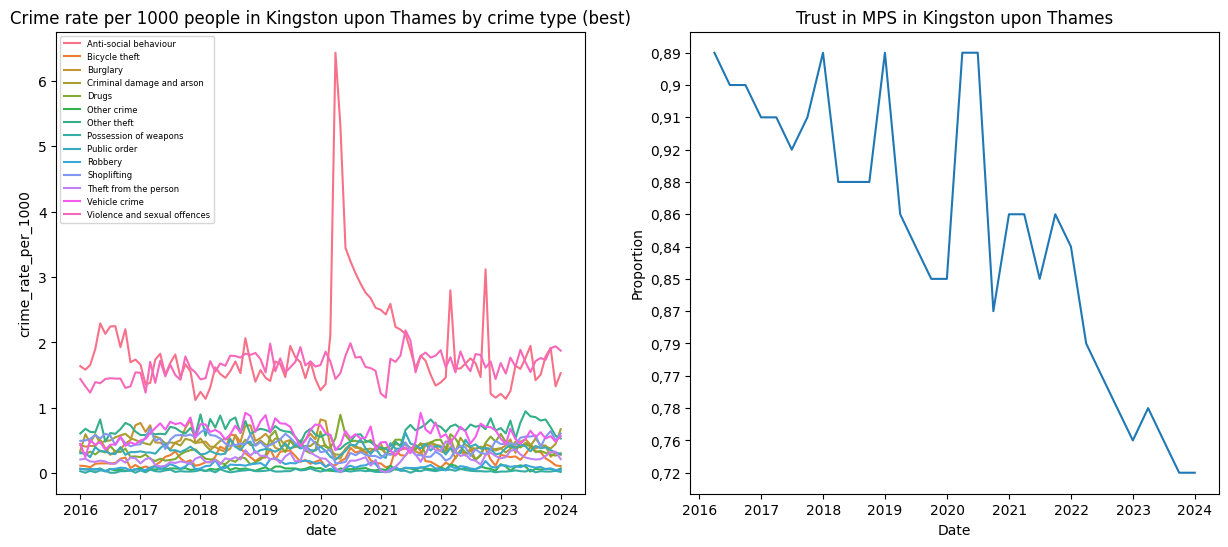

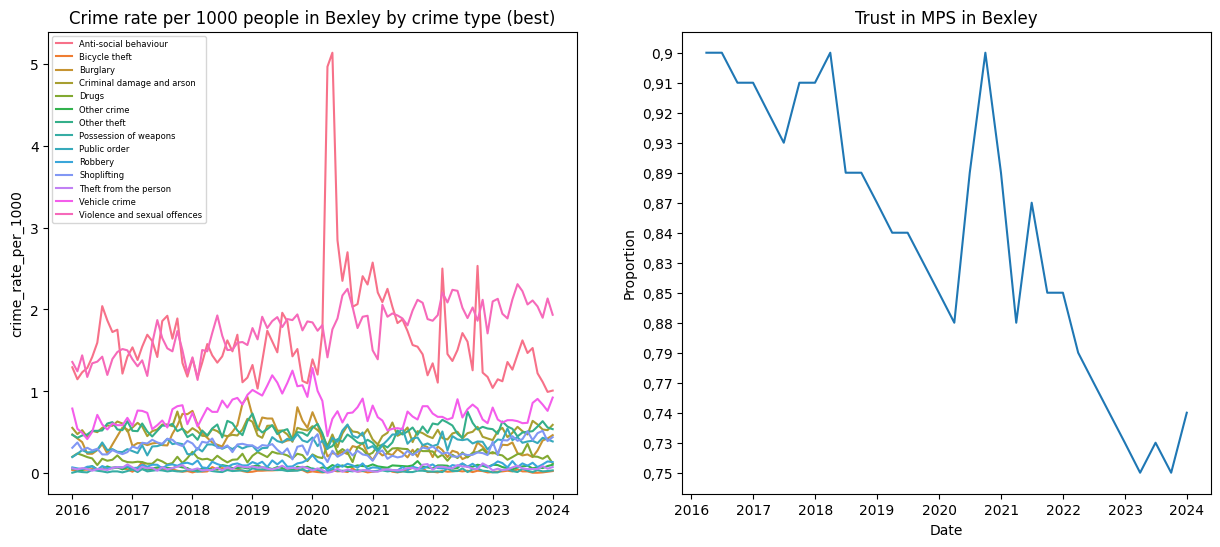

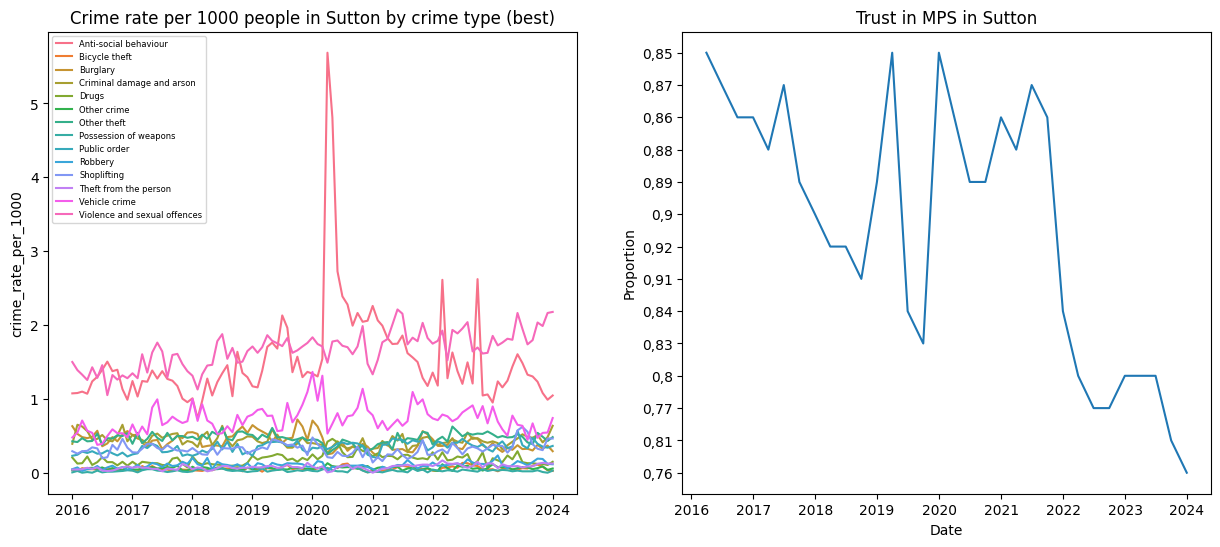

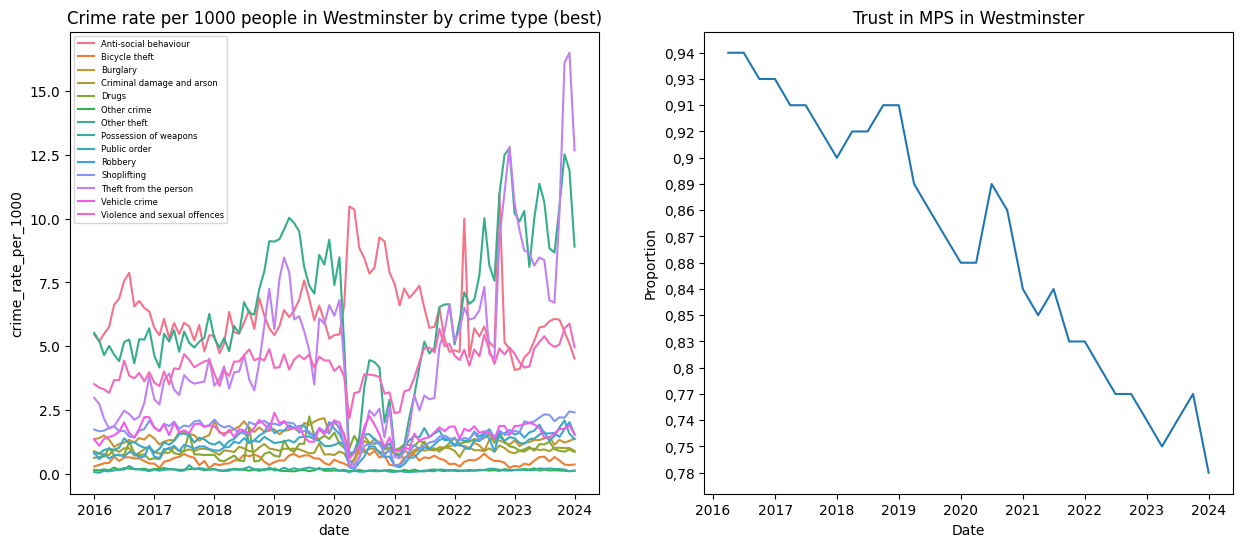

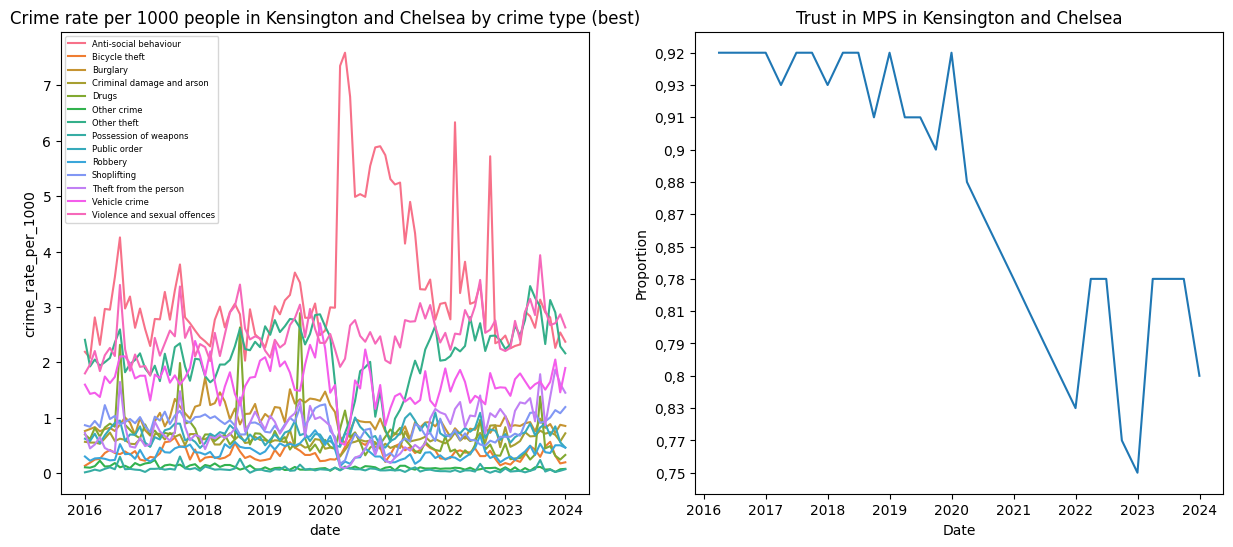

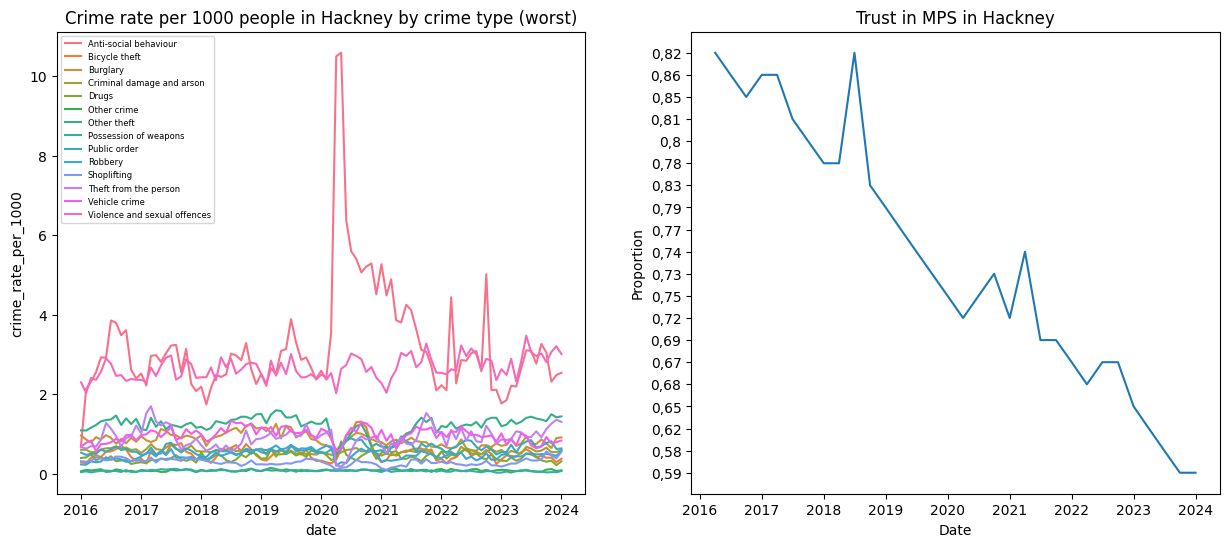

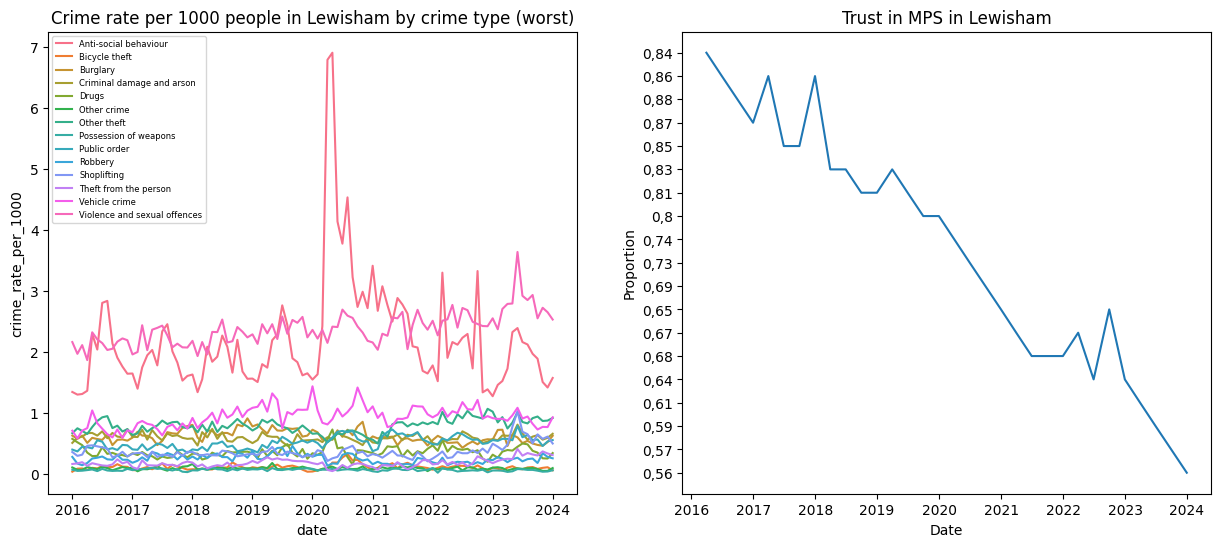

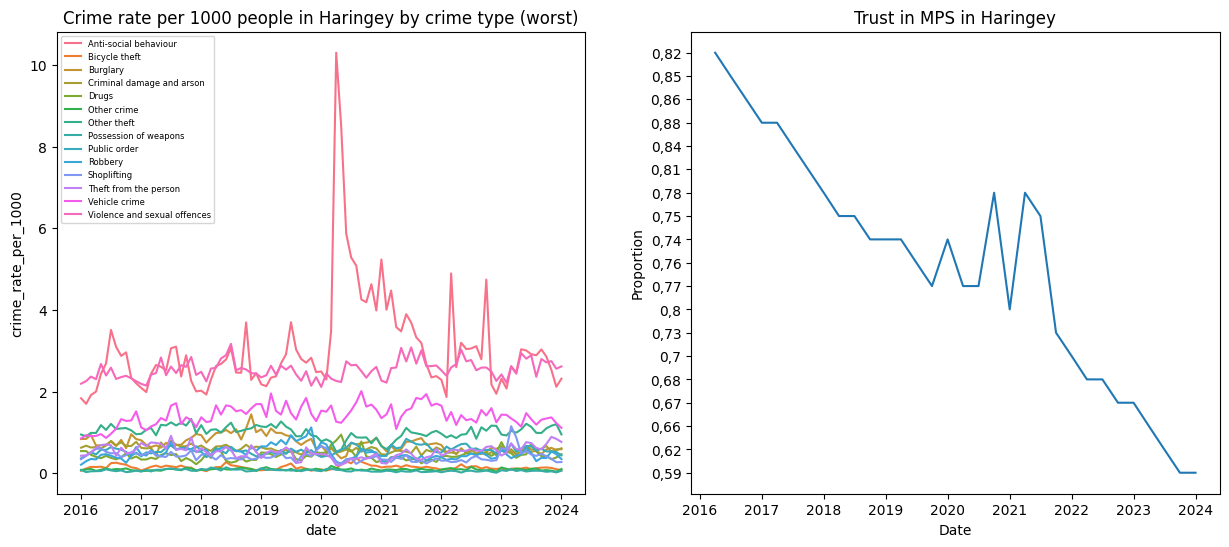

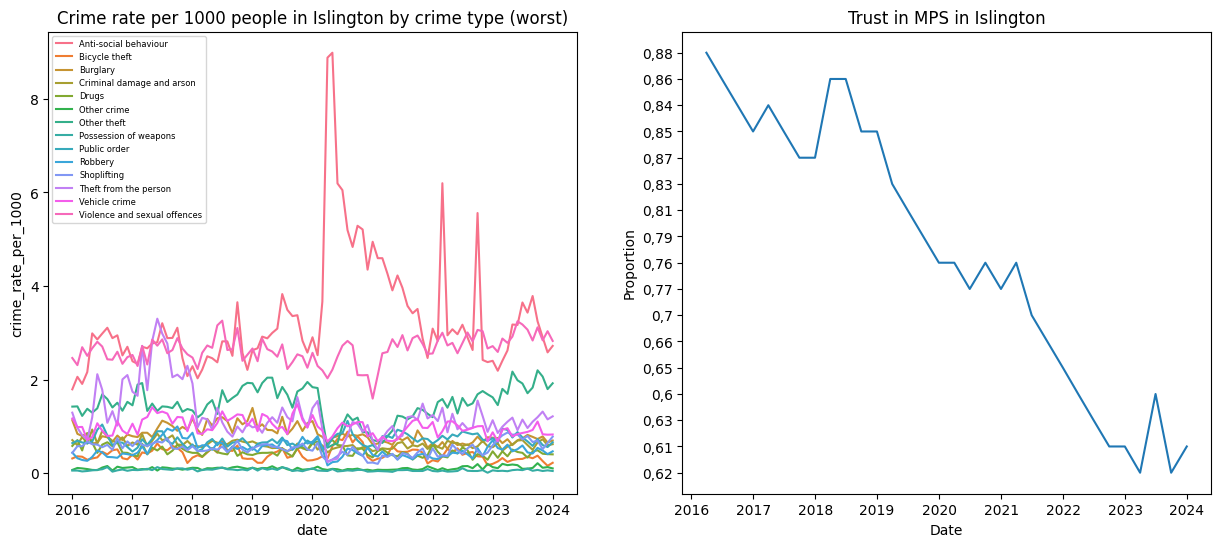

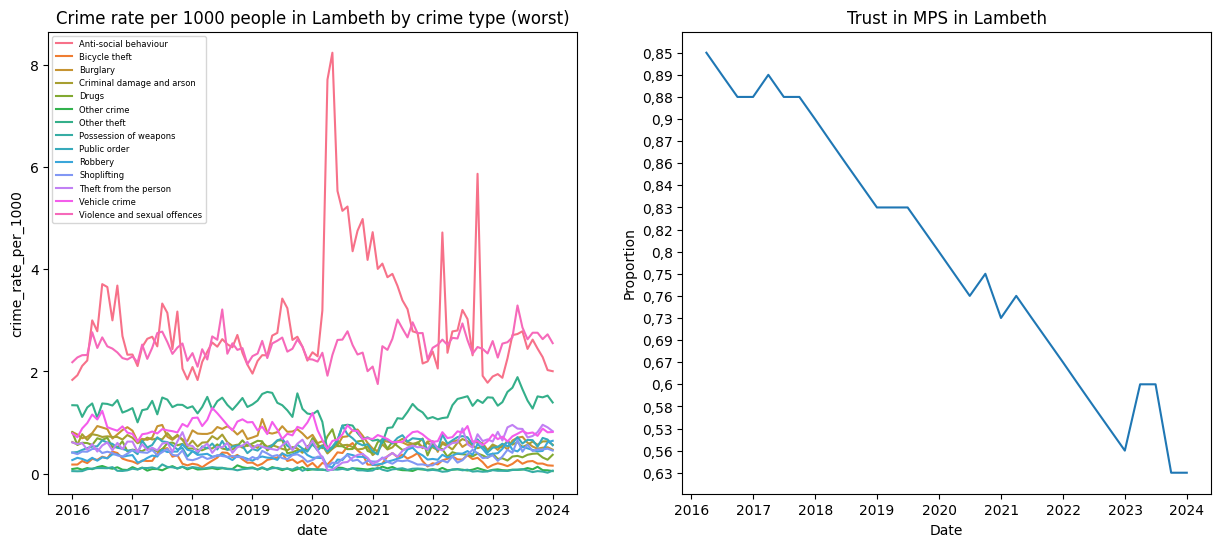

In [9]:
# for each borough, plot the crime rate per 1000 people of different crime types
import matplotlib.pyplot as plt
import seaborn as sns

for borough in best_boroughs:
    fig, axs = plt.subplots(1,2, figsize=(15, 6))
    df_borough = grouped_best_df[grouped_best_df['borough'] == borough]
    sns.lineplot(data=df_borough, x='date', y='crime_rate_per_1000', hue='Crime type', ax=axs[0])
    axs[0].set_title(f'Crime rate per 1000 people in {borough} by crime type (best)')
    axs[0].legend(loc='upper left', prop={'size': 6})
    df_trust_borough = df_trust_best[df_trust_best['Borough'] == borough]
    sns.lineplot(data=df_trust_borough, x='Date', y='Proportion', ax=axs[1])
    axs[1].set_title(f'Trust in MPS in {borough}')
    plt.show()

for borough in worst_boroughs:
    fig, axs = plt.subplots(1,2, figsize=(15, 6))
    df_borough = grouped_worst_df[grouped_worst_df['borough'] == borough]
    sns.lineplot(data=df_borough, x='date', y='crime_rate_per_1000', hue='Crime type', ax=axs[0])
    axs[0].set_title(f'Crime rate per 1000 people in {borough} by crime type (worst)')
    axs[0].legend(loc='upper left', prop={'size': 6})
    df_trust_borough = df_trust_worst[df_trust_worst['Borough'] == borough]
    sns.lineplot(data=df_trust_borough, x='Date', y='Proportion', ax=axs[1])
    axs[1].set_title(f'Trust in MPS in {borough}')
    plt.show()


In [10]:
df_trust

Date Survey               Borough    Measure Proportion   MPS
6720  31/03/2016    PAS  Barking and Dagenham  Trust MPS       0,83  0,86
6721  31/03/2016    PAS                Barnet  Trust MPS       0,87  0,86
6722  31/03/2016    PAS                Bexley  Trust MPS        0,9  0,86
6723  31/03/2016    PAS                 Brent  Trust MPS       0,83  0,86
6724  31/03/2016    PAS               Bromley  Trust MPS       0,88  0,86
...          ...    ...                   ...        ...        ...   ...
9275  31/12/2023    PAS                Sutton  Trust MPS       0,76  0,69
9276  31/12/2023    PAS         Tower Hamlets  Trust MPS       0,72  0,69
9277  31/12/2023    PAS        Waltham Forest  Trust MPS       0,57  0,69
9278  31/12/2023    PAS            Wandsworth  Trust MPS       0,69  0,69
9279  31/12/2023    PAS           Westminster  Trust MPS       0,78  0,69

[1024 rows x 6 columns]

In [11]:
crime_types = grouped_best_df['Crime type'].unique().tolist()
crime_types

['Anti-social behaviour',
 'Bicycle theft',
 'Burglary',
 'Criminal damage and arson',
 'Drugs',
 'Other crime',
 'Other theft',
 'Possession of weapons',
 'Public order',
 'Robbery',
 'Shoplifting',
 'Theft from the person',
 'Vehicle crime',
 'Violence and sexual offences']

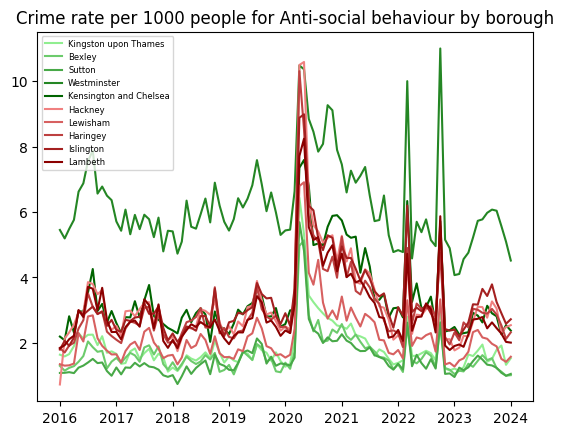

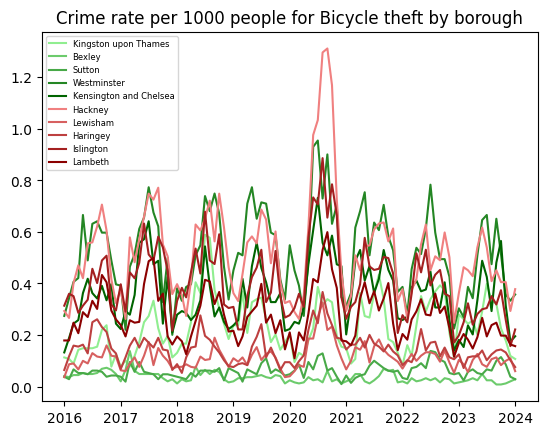

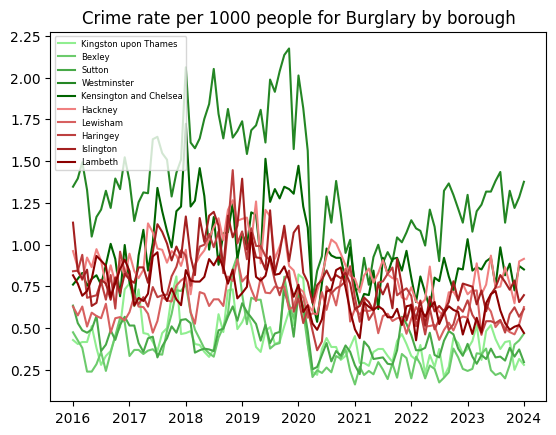

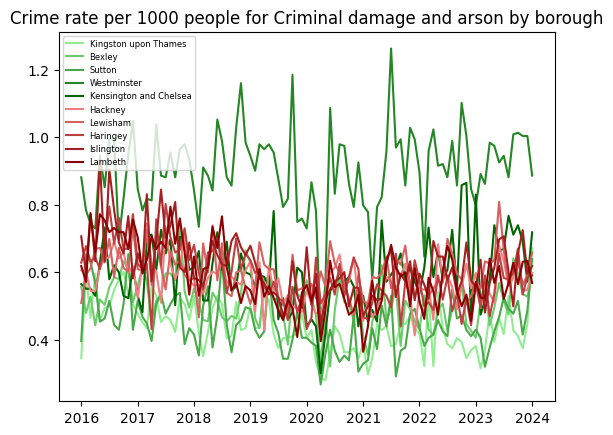

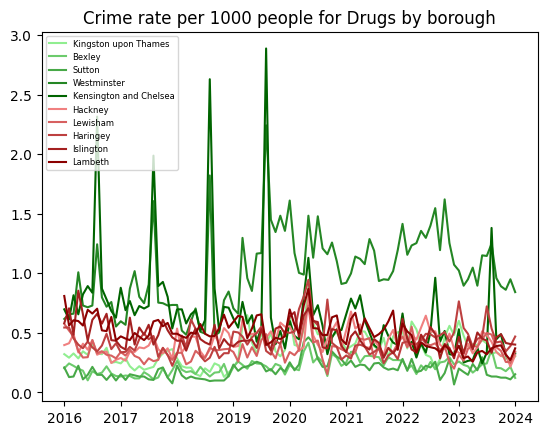

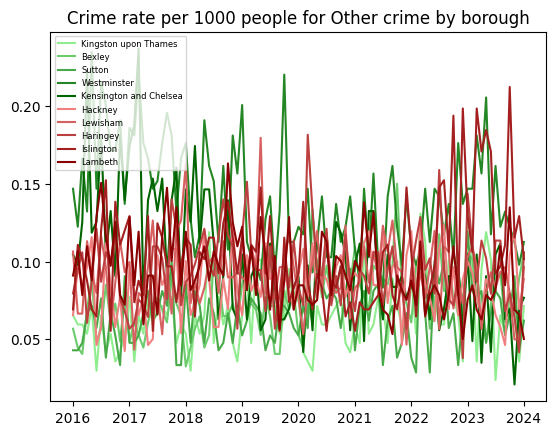

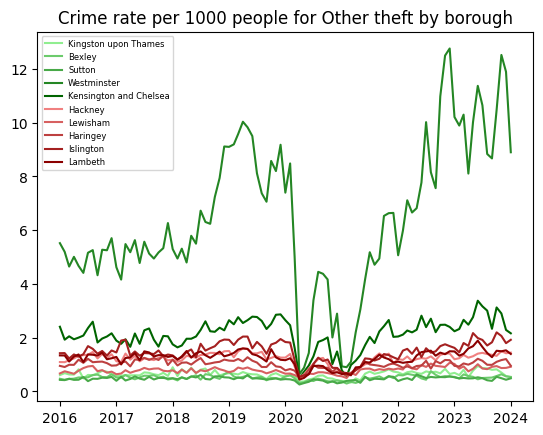

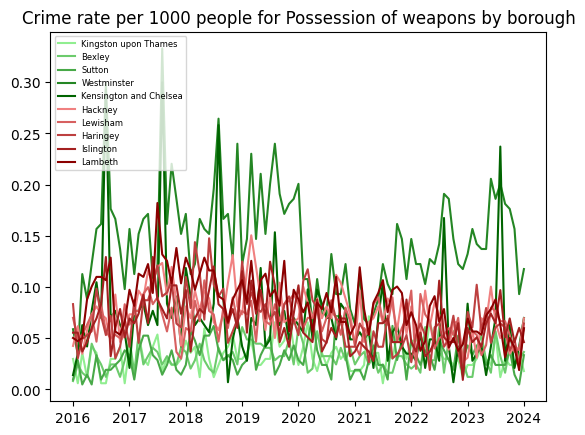

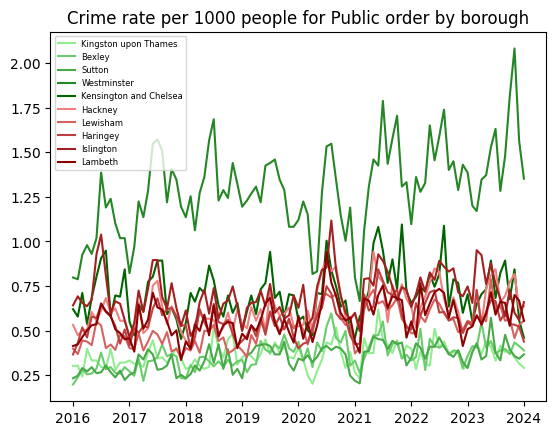

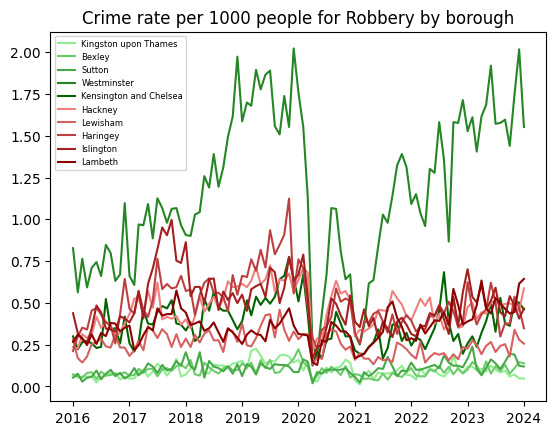

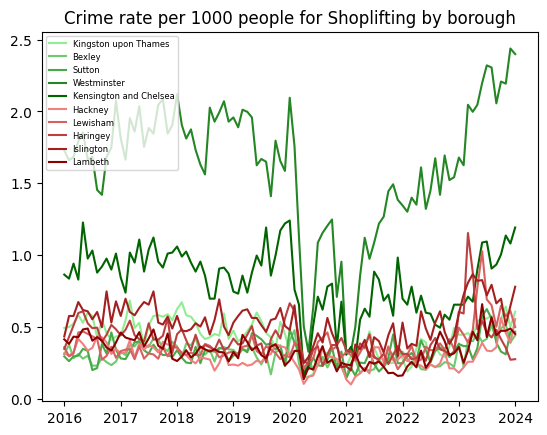

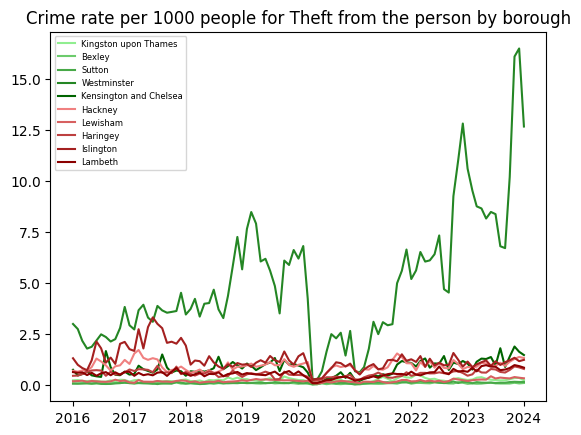

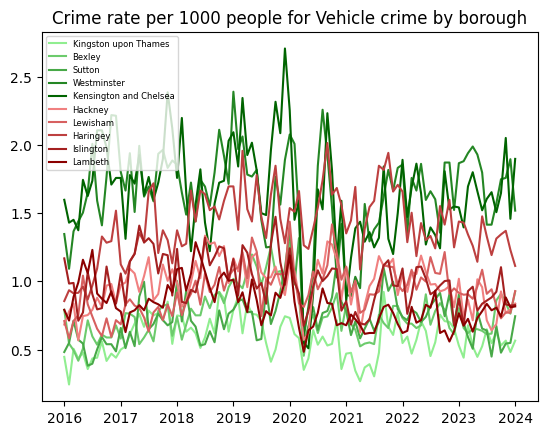

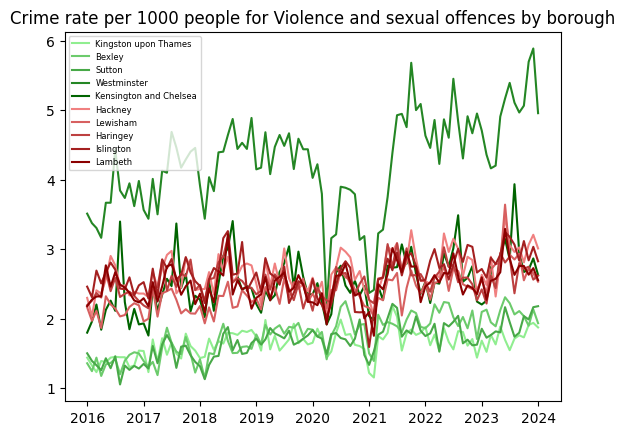

In [12]:
# make a graph for each crime type, where the best boroughs are green and the worst are red
import matplotlib.colors as mcolors

# Define colormaps for best and worst boroughs
cmap_best = mcolors.LinearSegmentedColormap.from_list("", ["lightgreen", "darkgreen"])
cmap_worst = mcolors.LinearSegmentedColormap.from_list("", ["lightcoral", "darkred"])

# Generate the colors for the boroughs
best_colors = [cmap_best(i / (len(best_boroughs) - 1)) for i in range(len(best_boroughs))]
worst_colors = [cmap_worst(i / (len(worst_boroughs) - 1)) for i in range(len(worst_boroughs))]

for crime in crime_types:
    fig = plt.plot(figsize=(15, 6))
    df_crime_best = grouped_best_df[grouped_best_df['Crime type'] == crime]
    df_crime_worst = grouped_worst_df[grouped_worst_df['Crime type'] == crime]
    for i, borough in enumerate(best_boroughs):
        df_borough = df_crime_best[df_crime_best['borough'] == borough]
        plt.plot(df_borough['date'], df_borough['crime_rate_per_1000'], label=borough, color=best_colors[i])

    for i, borough in enumerate(worst_boroughs):
        df_borough = df_crime_worst[df_crime_worst['borough'] == borough]
        plt.plot(df_borough['date'], df_borough['crime_rate_per_1000'], label=borough, color=worst_colors[i])
    plt.title(f'Crime rate per 1000 people for {crime} by borough')
    plt.legend(loc='upper left', prop={'size': 6})
    plt.show()
    

In [13]:
df_tourism = pd.read_csv('../data/tourism.csv')
df_tourism.columns = ['borough', 'oversees_visitors_spend(mil)', 'domestic_visitors_spend(mil)', 'day_visitors_spend(mil)', 'total_visitors_spend(mil)']
df_tourism = df_tourism[['borough', 'total_visitors_spend(mil)']]

df_tourism['borough'] = df_tourism['borough'].replace('Kingston-upon-Thames','Kingston upon Thames')

df_tourism['tourism_multiplier'] = df_tourism['total_visitors_spend(mil)'] / df_tourism['total_visitors_spend(mil)'].max() + 1

combined_boroughs = best_boroughs + worst_boroughs

df_tourism_selected = df_tourism[df_tourism['borough'].isin(combined_boroughs)]
df_tourism_selected['population'] = df_tourism_selected['borough'].map(populations)
df_tourism_selected['population_with_tourism'] = round(df_tourism_selected['population'] * df_tourism_selected['tourism_multiplier'],0)

df_tourism_selected

C:\Users\G2MIC\AppData\Local\Temp\ipykernel_25932\770217202.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tourism_selected['population'] = df_tourism_selected['borough'].map(populations)
C:\Users\G2MIC\AppData\Local\Temp\ipykernel_25932\770217202.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tourism_selected['population_with_tourism'] = round(df_tourism_selected['population'] * df_tourism_selected['tourism_multiplier'],0)


borough  total_visitors_spend(mil)  tourism_multiplier  \
3                   Bexley                        240            1.010914   
11                 Hackney                        219            1.009959   
13                Haringey                        253            1.011505   
18               Islington                        431            1.019600   
19  Kensington and Chelsea                       1868            1.084948   
20    Kingston upon Thames                        335            1.015234   
21                 Lambeth                        733            1.033333   
22                Lewisham                        229            1.010414   
28                  Sutton                        183            1.008322   
32             Westminster                       6068            1.275944   

    population  population_with_tourism  
3       246472                 249162.0  
11      259146                 261727.0  
13      264238                 267278.0  
18      216589                 220834.0  
19      143375                 155554.0  
20      168063                 170623.0  
21      318654                 329276.0  
22      300553                 303683.0  
28      209639                 211384.0  
32      204236                 260594.0

In [14]:
# add the population_with_tourism to the grouped_best_df

grouped_best_df['population_with_tourism'] = grouped_best_df['borough'].map(df_tourism_selected.set_index('borough')['population_with_tourism'])
grouped_worst_df['population_with_tourism'] = grouped_worst_df['borough'].map(df_tourism_selected.set_index('borough')['population_with_tourism'])

grouped_best_df['crime_rate_per_1000_with_tourism'] = (grouped_best_df['crime_count'] / grouped_best_df['population_with_tourism']) * 1000
grouped_worst_df['crime_rate_per_1000_with_tourism'] = (grouped_worst_df['crime_count'] / grouped_worst_df['population_with_tourism']) * 1000

grouped_best_df

borough                    Crime type  crime_count  population  \
0          Bexley         Anti-social behaviour          319      246472   
1          Bexley         Anti-social behaviour          283      246472   
2          Bexley         Anti-social behaviour          304      246472   
3          Bexley         Anti-social behaviour          317      246472   
4          Bexley         Anti-social behaviour          350      246472   
...           ...                           ...          ...         ...   
6784  Westminster  Violence and sexual offences         1014      204236   
6785  Westminster  Violence and sexual offences         1034      204236   
6786  Westminster  Violence and sexual offences         1163      204236   
6787  Westminster  Violence and sexual offences         1202      204236   
6788  Westminster  Violence and sexual offences         1012      204236   

      crime_rate_per_1000       date  population_with_tourism  \
0                1.294265 2016-01-01                 249162.0   
1                1.148203 2016-02-01                 249162.0   
2                1.233406 2016-03-01                 249162.0   
3                1.286150 2016-04-01                 249162.0   
4                1.420040 2016-05-01                 249162.0   
...                   ...        ...                      ...   
6784             4.964845 2023-09-01                 260594.0   
6785             5.062771 2023-10-01                 260594.0   
6786             5.694393 2023-11-01                 260594.0   
6787             5.885348 2023-12-01                 260594.0   
6788             4.955052 2024-01-01                 260594.0   

      crime_rate_per_1000_with_tourism  
0                             1.280292  
1                             1.135807  
2                             1.220090  
3                             1.272265  
4                             1.404709  
...                                ...  
6784                          3.891110  
6785                          3.967858  
6786                          4.462881  
6787                          4.612539  
6788                          3.883436  

[6789 rows x 8 columns]

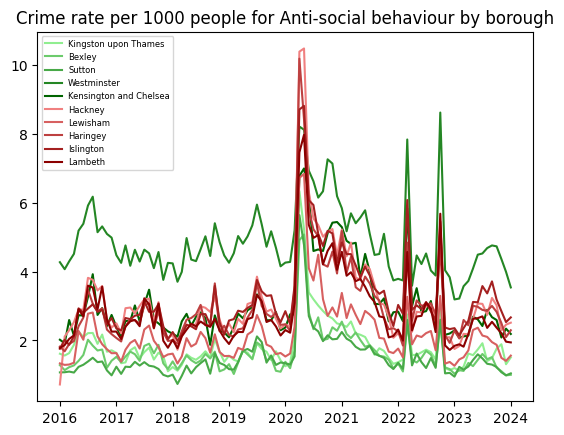

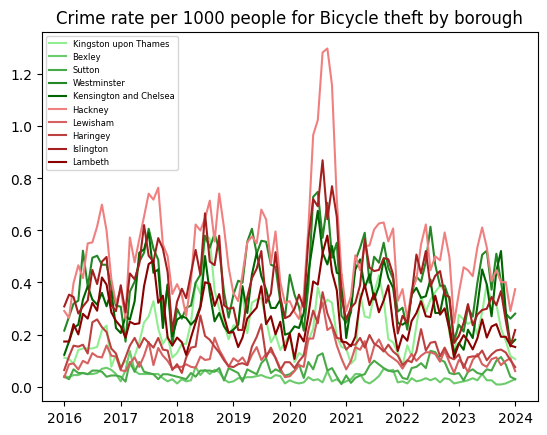

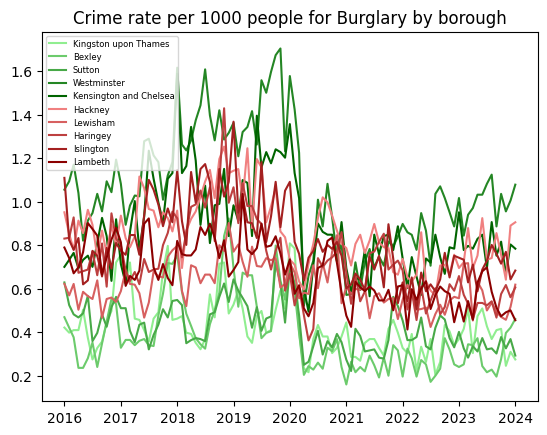

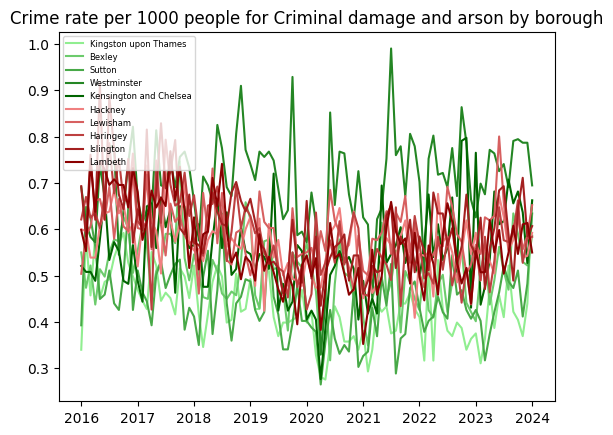

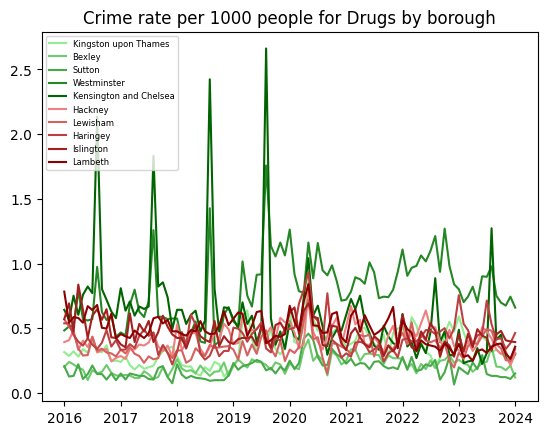

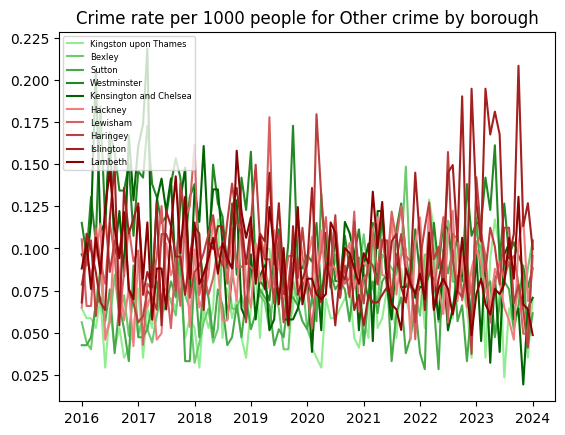

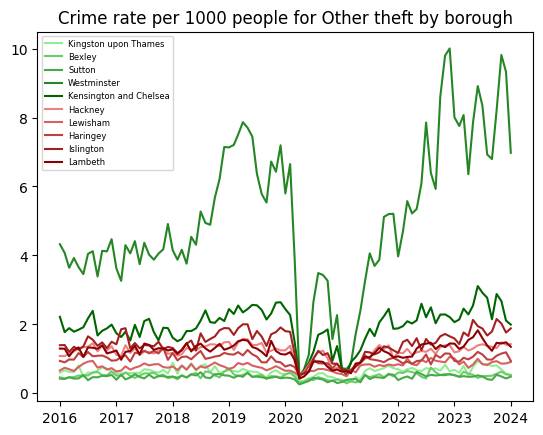

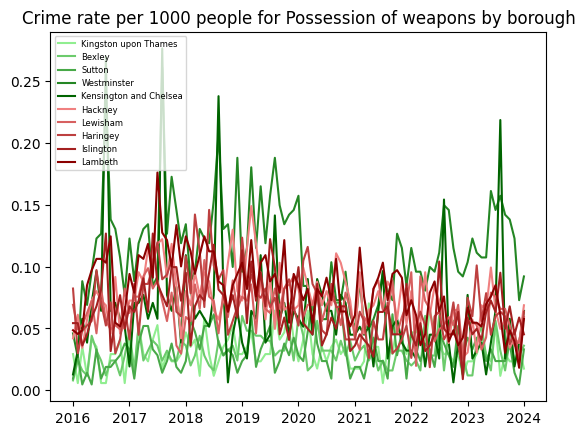

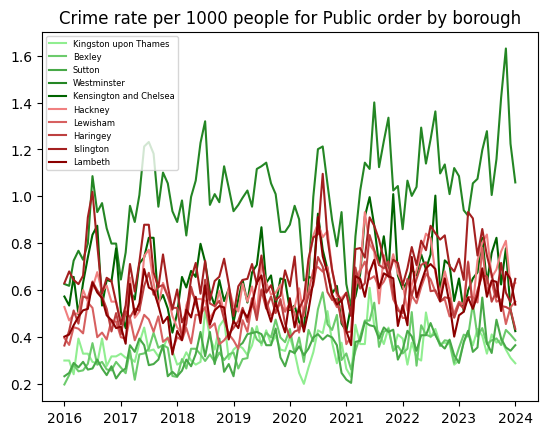

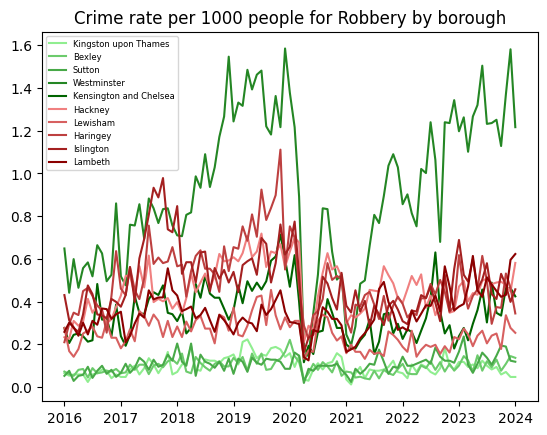

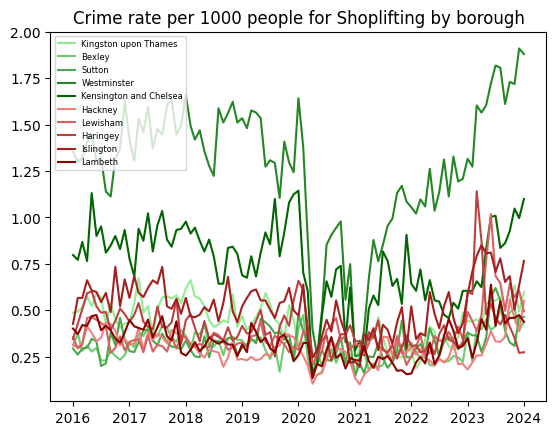

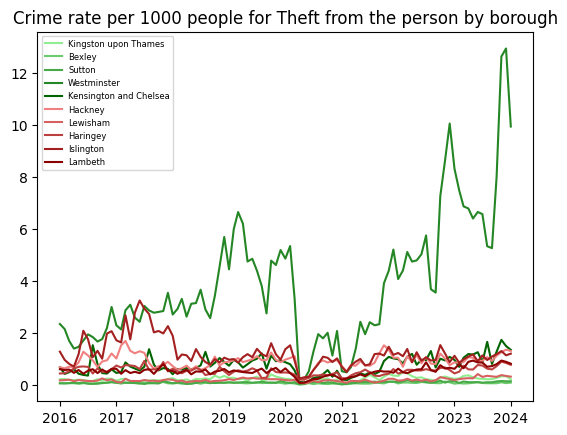

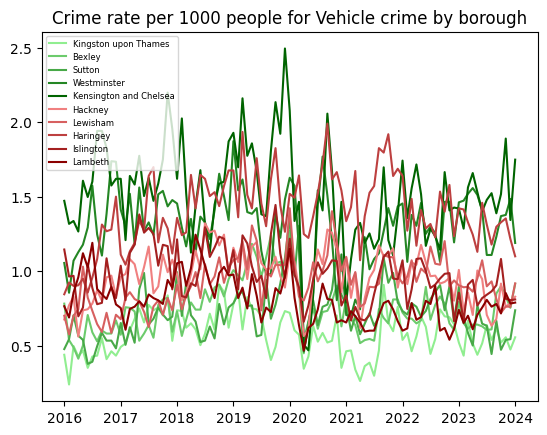

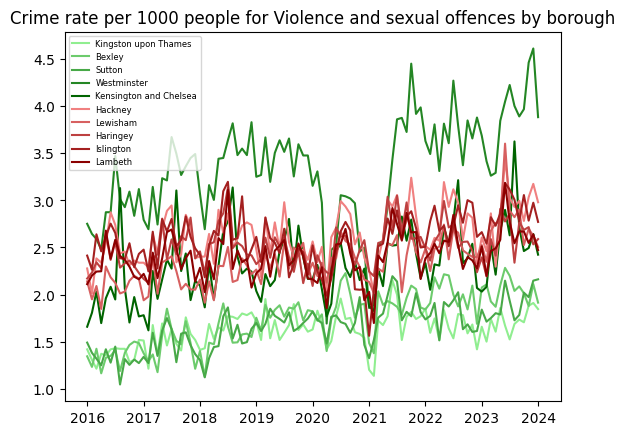

In [15]:
# make a same crime plots as before but now with the population_with_tourism
import matplotlib.colors as mcolors

# Define colormaps for best and worst boroughs
cmap_best = mcolors.LinearSegmentedColormap.from_list("", ["lightgreen", "darkgreen"])
cmap_worst = mcolors.LinearSegmentedColormap.from_list("", ["lightcoral", "darkred"])

# Generate the colors for the boroughs
best_colors = [cmap_best(i / (len(best_boroughs) - 1)) for i in range(len(best_boroughs))]
worst_colors = [cmap_worst(i / (len(worst_boroughs) - 1)) for i in range(len(worst_boroughs))]

for crime in crime_types:
    fig = plt.plot(figsize=(15, 6))
    df_crime_best = grouped_best_df[grouped_best_df['Crime type'] == crime]
    df_crime_worst = grouped_worst_df[grouped_worst_df['Crime type'] == crime]
    for i, borough in enumerate(best_boroughs):
        df_borough = df_crime_best[df_crime_best['borough'] == borough]
        plt.plot(df_borough['date'], df_borough['crime_rate_per_1000_with_tourism'], label=borough, color=best_colors[i])

    for i, borough in enumerate(worst_boroughs):
        df_borough = df_crime_worst[df_crime_worst['borough'] == borough]
        plt.plot(df_borough['date'], df_borough['crime_rate_per_1000_with_tourism'], label=borough, color=worst_colors[i])
    plt.title(f'Crime rate per 1000 people for {crime} by borough')
    plt.legend(loc='upper left', prop={'size': 6})
    plt.show()
    

In [16]:
#make westminster pink and save the plots in a html file

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Define colormaps for best and worst boroughs
cmap_best = mcolors.LinearSegmentedColormap.from_list("", ["lightgreen", "darkgreen"])
cmap_worst = mcolors.LinearSegmentedColormap.from_list("", ["lightcoral", "darkred"])

# Generate the colors for the boroughs
best_colors = [cmap_best(i / (len(best_boroughs) - 1)) for i in range(len(best_boroughs))]
worst_colors = [cmap_worst(i / (len(worst_boroughs) - 1)) for i in range(len(worst_boroughs))]

# Directory to save the plots
output_dir = 'crime_plots'
os.makedirs(output_dir, exist_ok=True)

html_content = '<html><body>'

for crime in crime_types:
    fig, ax = plt.subplots(figsize=(15, 6))
    df_crime_best = grouped_best_df[grouped_best_df['Crime type'] == crime]
    df_crime_worst = grouped_worst_df[grouped_worst_df['Crime type'] == crime]

    for i, borough in enumerate(best_boroughs):
        df_borough = df_crime_best[df_crime_best['borough'] == borough]
        color = 'blue' if borough == 'Westminster' else best_colors[i]
        ax.plot(df_borough['date'], df_borough['crime_rate_per_1000_with_tourism'], label=borough, color=color)

    for i, borough in enumerate(worst_boroughs):
        df_borough = df_crime_worst[df_crime_worst['borough'] == borough]
        color = 'pink' if borough == 'Westminster' else worst_colors[i]
        ax.plot(df_borough['date'], df_borough['crime_rate_per_1000_with_tourism'], label=borough, color=color)

    ax.set_title(f'Crime rate per 1000 people for {crime} by borough')
    ax.legend(loc='upper left', prop={'size': 6})

    # Save plot as an image
    plot_filename = f'{output_dir}/{crime}_crime_rate_plot.png'
    plt.savefig(plot_filename)
    plt.close(fig)

    # Add plot to HTML content
    html_content += f'<h2>{crime} Crime Rate</h2><img src="{plot_filename}" style="width:100%;"><br>'

html_content += '</body></html>'

# Save HTML content to a file
html_filename = 'crime_rate_plots.html'
with open(html_filename, 'w') as html_file:
    html_file.write(html_content)

print(f'Plots have been saved and HTML file generated: {html_filename}')


Plots have been saved and HTML file generated: crime_rate_plots.html


In [17]:
df_crime_best_grouped = grouped_best_df.groupby(['Crime type', 'date']).agg({'crime_rate_per_1000_with_tourism': 'mean'}).reset_index()
df_crime_best_grouped['borough'] = 'Most trusting Boroughs'

df_crime_worst_grouped = grouped_worst_df.groupby(['Crime type', 'date']).agg({'crime_rate_per_1000_with_tourism': 'mean'}).reset_index()
df_crime_worst_grouped['borough'] = 'Least trusting Boroughs'

df_crime_grouped = pd.concat([df_crime_best_grouped, df_crime_worst_grouped])
df_crime_grouped

Crime type       date  \
0            Anti-social behaviour 2016-01-01   
1            Anti-social behaviour 2016-02-01   
2            Anti-social behaviour 2016-03-01   
3            Anti-social behaviour 2016-04-01   
4            Anti-social behaviour 2016-05-01   
...                            ...        ...   
1353  Violence and sexual offences 2023-09-01   
1354  Violence and sexual offences 2023-10-01   
1355  Violence and sexual offences 2023-11-01   
1356  Violence and sexual offences 2023-12-01   
1357  Violence and sexual offences 2024-01-01   

      crime_rate_per_1000_with_tourism                  borough  
0                             2.050156   Most trusting Boroughs  
1                             1.950408   Most trusting Boroughs  
2                             2.165397   Most trusting Boroughs  
3                             2.170674   Most trusting Boroughs  
4                             2.562290   Most trusting Boroughs  
...                                ...                      ...  
1353                          2.823669  Least trusting Boroughs  
1354                          2.743923  Least trusting Boroughs  
1355                          2.755954  Least trusting Boroughs  
1356                          2.789333  Least trusting Boroughs  
1357                          2.663715  Least trusting Boroughs  

[2716 rows x 4 columns]

In [18]:
# plot the average crime rate per 1000 people for each crime type for the best and worst boroughs
color_mapping = {'Most trusting Boroughs': 'green', 'Least trusting Boroughs': 'red'}

html_content_1 = '<html><body>'

for crime in crime_types:
    fig, ax = plt.subplots(figsize=(15, 6))
    df_crime = df_crime_grouped[df_crime_grouped['Crime type'] == crime]
    for borough in df_crime['borough'].unique():
        df_borough = df_crime[df_crime['borough'] == borough]
        ax.plot(df_borough['date'], df_borough['crime_rate_per_1000_with_tourism'], label=borough, color=color_mapping[borough])

    ax.set_title(f'Average crime rate per 1000 people for {crime} by borough type')
    ax.legend(loc='upper left', prop={'size': 6})

    plot_filename = f'{output_dir}/{crime}_average_crime_rate_plot.png'
    plt.savefig(plot_filename)
    plt.close(fig)
    
    html_content_1 += f'<h2>{crime} Crime Rate</h2><img src="{plot_filename}" style="width:100%;"><br>'

html_content_1 += '</body></html>'
html_filename_1 = 'average_crime_rate_plots.html'
with open(html_filename_1, 'w') as html_file_1:
    html_file_1.write(html_content_1)

print('plots saved to html file: average_crime_rate_plots.html')

plots saved to html file: average_crime_rate_plots.html


In [19]:
# save df_crime_grouped to a csv file
df_crime_grouped.to_csv('presentation_dataframes/average_crime_rate.csv', index=False)